In [1]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


In [1]:
import wandb
import tensorflow as tf
from wandb.keras import WandbCallback
from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFECV
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_validate
from sklearn.linear_model import Ridge
from scipy import stats
import random
from scipy.stats import sem
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.feature_selection import SelectKBest, mutual_info_regression

# Appropriateness Dataset without Augmented Data

In [2]:
jerks_path = "Dataset/Appropriateness_Features/mean_jerk_values.csv"
XX_jerks = pd.read_csv(jerks_path) # With Spine joint and Name of "Cond/StudySeq"

accels_path = "Dataset/Appropriateness_Features/mean_acceleration_values.csv"
XX_accels = pd.read_csv(accels_path) # With Spine joint and Name of "Cond/StudySeq"

pairwise_path = "Dataset/Appropriateness_Features/mean_pairwise_joint_distances.csv"
XX_pairwise = pd.read_csv(pairwise_path) # With Spine joint and Name of "Cond/StudySeq"
XX_pairwise.drop(XX_pairwise.columns[range(1,15)], axis=1, inplace=True) # Without Spine Joint but with Name of "Cond/StudySeq"

rms_properties_path = "Dataset/Appropriateness_Features/RMS_Energy_properties.csv"
XX_rms_energy_properties = pd.read_csv(rms_properties_path, index_col = False) # With Name of StudySeq

rms_distance_path = "Dataset/Appropriateness_Features/RMS_Distance_scores_fd_scaled.csv"
XX_rms_distance_scores = pd.read_csv(rms_distance_path)
XX_rms_distance_scores.drop(XX_rms_distance_scores.columns[1], axis=1, inplace=True) # Dropping the Spine joint (always 0)

labels_path = "Dataset/Appropriateness_Labels/mean_opinion_scores.csv"
YY = pd.read_csv(labels_path) # # With Name of "Cond/StudySeq"

In [3]:
XY = XX_jerks.join(YY, lsuffix="_jerks", rsuffix="_YY")
XY = XY.join(XX_accels, rsuffix='_accels')
XY = XY.rename(columns={'Unnamed: 0': 'Unnamed: 0_accels'})
XY = XY.join(XX_pairwise, rsuffix='_pairwise')
XY = XY.rename(columns={'Unnamed: 0': 'Unnamed: 0_pairwise'})
XY = XY.join(XX_rms_distance_scores)
XY = XY.rename(columns={'Unnamed: 0': 'Unnamed: 0_rms_distance_scores'})

In [4]:
# Join the RMS Energy Properties Features
XY = XY.rename(columns={'Unnamed: 0_jerks': 'StudySeq'})
XY['StudySeq'] = XY['StudySeq'].apply(lambda x: x[8:])
XY = XY.join(XX_rms_energy_properties, rsuffix='_rms')
for i in range(1,int(XY.shape[0]/40)):
    XY.iloc[i*40:(i+1)*40,-5:] = XX_rms_energy_properties

In [5]:
# Drop the Names of "Cond/StudySeq" and remaining information relating to the "Spine" joint
# Also Drop the Index from rms_energy
XY.drop(['StudySeq','Unnamed: 0_YY','Unnamed: 0_accels', 'Unnamed: 0_pairwise', 'Spine', 'Spine_accels',
        'Unnamed: 0_rms_distance_scores', 'Unnamed: 0', 'StudySeq_rms'], axis=1, inplace=True)

rename_dict = dict(zip(XY.columns[0:14], XY.columns[0:14] + '_jerks'))
XY = XY.rename(columns=rename_dict)

# Jerk for 14 joints + Acceleration for 14 joints + 14 choose 2 pairwise distance + 14 RMS Energy Distance Scores + 3 RMS Energy Property Features + Label for MOS = 137
print(XY.shape)

(360, 137)


In [6]:
XX = XY.drop(['Mean_Appropriateness_Score'], axis=1, inplace=False)
bad_features = ['LeftShoulder_vs_LeftArm', 'LeftArm_vs_LeftForeArm', 'LeftForeArm_vs_LeftHand',
                'RightShoulder_vs_RightArm', 'RightArm_vs_RightForeArm','RightForeArm_vs_RightHand']
XX.drop(bad_features, axis=1, inplace=True)
YY = XY.loc[:,'Mean_Appropriateness_Score']
XX = np.log(XX)
XX.iloc[:,-17:-3] = XX.iloc[:,-17:-3]
print(XX.shape)
print(YY.shape)

(360, 130)
(360,)


# Functions

In [7]:
def validation_curve(model, XX, YY, param_grid, log_bool, extra_string, xticks, x_vals, xlabel):
    n_splits = 5
    outer_loop_cv = KFold(n_splits = n_splits, shuffle = True)
    outer_val_mse = []
    outer_train_mse = []
    folds = outer_loop_cv.split(XX)
    count = 1
    for train, test in folds:
        XX_train = XX.iloc[train]
        YY_train = YY.iloc[train]
        YY_train = YY_train.values.flatten()
        
        cv_model = GridSearchCV(estimator = model, param_grid = param_grid, scoring = "neg_mean_squared_error", 
                                    cv = KFold(n_splits = 5, shuffle = True), return_train_score=True)
        callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20)
        
        cv_model.fit(XX_train, YY_train, epochs=250, batch_size=288, verbose=False, shuffle=True, callbacks = [callback])
        
        
        train_mse = -1 * cv_model.cv_results_["mean_train_score"]
        val_mse = -1 * cv_model.cv_results_["mean_test_score"]
        
        outer_train_mse = outer_train_mse + [train_mse]
        outer_val_mse = outer_val_mse + [val_mse]
        print('Fold ', count, '/', n_splits, ' Complete.')
        count = count + 1
        
    mean_train_mse = np.mean(np.asarray(outer_train_mse), axis=0)
    mean_val_mse = np.mean(np.asarray(outer_val_mse), axis=0)
    
    train_mse_sem = sem(np.asarray(outer_train_mse), axis=0)
    val_mse_sem = sem(np.asarray(outer_val_mse), axis=0)
    
    plt.figure(figsize = (6,4))
    plt.plot(x_vals, mean_train_mse, label='Training Set MSE')
    plt.fill_between(x_vals, mean_train_mse - train_mse_sem, mean_train_mse + train_mse_sem, alpha=0.5)
    plt.plot(x_vals, mean_val_mse, label='Validation Set MSE')
    plt.fill_between(x_vals, mean_val_mse - val_mse_sem, mean_val_mse + val_mse_sem, alpha=0.5)
    if log_bool == True:
        plt.xscale('log')
    plt.xlim(min(xticks),max(xticks))
    plt.xticks(xticks)
    plt.ylim(0, max([max(mean_train_mse), max(mean_val_mse)]) + max([max(train_mse_sem), max(val_mse_sem)]))
    plt.ylabel('MSE')
    plt.xlabel(xlabel)
    plt.title('ANN performance on varying ' + extra_string)
    plt.legend()
    
    print('Best Param: ', x_vals[np.where(mean_val_mse == min(mean_val_mse))])
    

In [8]:
def predicted_vs_true(model, XX, YY, epochs, validation_split, batch_size, callback):
    n_splits = 5
    outer_loop_cv = KFold(n_splits = n_splits, shuffle = True)
    folds = outer_loop_cv.split(XX)
    count = 1
    YY_train_true = []
    YY_train_preds = []
    YY_preds = []
    YY_true = []
    model.save_weights('initial_app.h5')
    for train, test in folds:
        model.load_weights('initial_app.h5')
        XX_train = XX.iloc[train]
        YY_train = YY.iloc[train]
        XX_test= XX.iloc[test]
        YY_test = YY.iloc[test]
        YY_train, YY_test = YY_train.values.flatten(), YY_test.values.flatten()
        
        model.fit(XX_train, YY_train, epochs=epochs, validation_split=validation_split,
                  batch_size=batch_size, verbose = 0, callbacks = [callback])
        
        YY_train_preds = YY_train_preds + list(model.predict(XX_train))
        YY_train_true = YY_train_true + list(YY_train)
        
        YY_pred = model.predict(XX_test).flatten()
        
        YY_true = YY_true + list(YY_test)
        YY_preds = YY_preds + list(YY_pred)
        print('Fold ', count, '/', n_splits, ' Complete.')
        count = count + 1
    
    m, b = np.polyfit(YY_preds, YY_true, 1)
    x = np.arange(0,101)
    y = np.arange(0,101)
    
    plt.figure(figsize = (7,7))
    plt.scatter(YY_preds, YY_true, s=7.5, alpha=0.8, label='Predictions')
    plt.plot(x, y*m + b, '-c', label="Regression Line for predictions")
    plt.plot(x, y, "-k", label="Regression Line for p=1", alpha=0.5)
    plt.title("Predictions of ANN on Test Set")
    plt.ylabel("True Appropriateness")
    plt.xlabel("Predicted Appropriateness")
    plt.xticks(np.linspace(0,100,11))
    plt.yticks(np.linspace(0,100,11))
    plt.xlim(0,100)
    plt.ylim(0,100)
    plt.legend()

    rho, pval = stats.spearmanr(YY_true, YY_preds)
    print("Pearson Correlation Coefficient =", rho)
    print("Test Mean Squared Error = ", mean_squared_error(YY_true, YY_preds, squared=True))
    print("Train Mean Squared Error = ", mean_squared_error(YY_train_true, YY_train_preds, squared=True))

In [9]:
def create_ann(neurons_grid):
    input_dim = 130
    output_dim = 1
    
    model = Sequential()
    model.add(Dense(neurons_grid[0], input_dim=input_dim, activation='relu'))
    
    for layer in neurons_grid[1:]:
        model.add(Dense(layer, activation='relu'))
        
    model.add(Dense(output_dim))
    
    model.compile(optimizer = 'adam', loss='mse')
    
    return model

In [10]:
def create_neuron_grid(neurons_per_layer, layer_cap):
    neuron_grid = []
    for i in range(1,layer_cap+1):
        neuron_grid = neuron_grid + [[neurons_per_layer]*i]
    return neuron_grid

In [11]:
def reduce_by_fs_score(XX, YY, threshold):
    scores = mutual_info_regression(XX, YY, discrete_features = False)
    reduced_XX = XX.drop(XX.columns[np.where(scores < threshold)], axis=1, inplace=False)
    return reduced_XX

In [12]:
def feature_curve(XX, YY, param_grid, xticks):
    n_splits = 5
    outer_loop_cv = KFold(n_splits = n_splits, shuffle = True)
    outer_val_mse = []
    outer_train_mse = []
    folds = outer_loop_cv.split(XX)
    count = 1
    for train, test in folds:
        XX_train = XX.iloc[train]
        YY_train = YY.iloc[train]
        YY_train = YY_train.values.flatten()
        
        val_scores = []
        train_scores = []
        for threshold in param_grid:
            reduced_XX_train = reduce_by_fs_score(XX_train, YY_train, threshold)
            
            model = Sequential()
            model.add(Dense(14, input_dim=len(reduced_XX_train.columns), activation='relu')) # hidden layer 1
            model.add(Dense(14)) #2 
            model.add(Dense(14)) #3 
            model.add(Dense(14)) #4 
            model.add(Dense(14)) #5 
            model.add(Dense(14)) #6
            model.add(Dense(1))
            model.add(Dense(1))
            model.compile(optimizer = 'adam', loss='mse')
            
            callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20)
            
            history = model.fit(reduced_XX_train, YY_train, epochs=250, validation_split=0.2, batch_size=288, verbose = 0, 
                 callbacks = [callback])

            
            val_scores = val_scores + [history.history['val_loss'][history.history['loss'].index(min(history.history['loss']))]]
            train_scores = train_scores + [min(history.history['loss'])]

        outer_val_mse = outer_val_mse + [val_scores]
        outer_train_mse = outer_train_mse + [train_scores]
        print('Fold ', count, '/', n_splits, ' Complete.')
        count = count + 1
        
    mean_val_mse = np.mean(np.asarray(outer_val_mse), axis=0)
    mean_train_mse = np.mean(np.asarray(outer_train_mse), axis=0)
    
    plt.figure(figsize=(6,4))
    plt.plot(param_grid, mean_train_mse, label='MSE on Training Set')
    plt.plot(param_grid, mean_val_mse, label='MSE on Validation Set')
    plt.xlim(min(param_grid), max(param_grid))
    plt.xticks(xticks)
    plt.ylim(0, max(mean_val_mse) + max(mean_val_mse)*0.05)
    plt.ylabel('MSE')
    plt.xlabel('Mutual Information Score Threshold')
    plt.title('ANN performance on varying Mutual Information Score Threshold')
    plt.legend()
    
    print('Best Mutual Information Score Threshold: ', param_grid[np.where(mean_val_mse == (min(mean_val_mse)))[0]])

# Baseline ANN without feature selection

Learning Curves (Training set size vs MSE)

In [ ]:
# TODO

In [ ]:
# TODO

Validation Curves

C:\Users\Cameron\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  


Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Best Param:  [14]
Time taken:  1345.094591140747


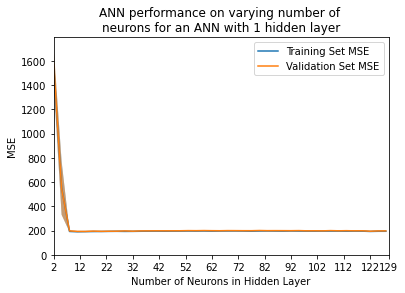

In [78]:
start_time = time.time()
model =  KerasRegressor(build_fn=create_ann, verbose = False)  
param_grid = {'neurons_grid': [[x] for x in np.arange(2,130,3)]}
validation_curve(model, XX, YY, param_grid, False, 'number of \nneurons for an ANN with 1 hidden layer', 
                 np.append(np.arange(2,129,10), 129), np.arange(2,130,3), 'Number of Neurons in Hidden Layer')
print("Time taken: ", time.time() - start_time)

C:\Users\Cameron\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  


Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Best Param:  [6]
Time taken:  534.4964110851288


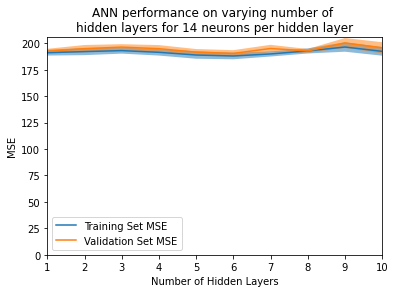

In [79]:
start_time = time.time()
model =  KerasRegressor(build_fn=create_ann, verbose = False)  
param_grid = {'neurons_grid': create_neuron_grid(14,10)}
validation_curve(model, XX, YY, param_grid, False, 'number of \nhidden layers for 14 neurons per hidden layer' , 
                 np.arange(1,11,1), np.arange(1,11,1), 'Number of Hidden Layers')
print("Time taken: ", time.time() - start_time)

Predicted vs True

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Pearson Correlation Coefficient = 0.5037312883400261
Test Mean Squared Error =  132.49331354266096
Train Mean Squared Error =  117.72911589165712
Time taken:  12.544025897979736


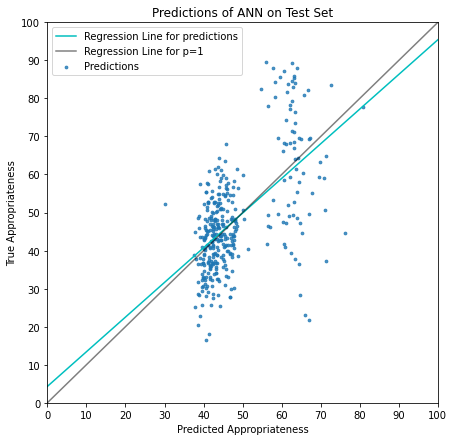

In [36]:
start_time = time.time()
model = Sequential()
model.add(Dense(14, input_dim=130, activation='relu')) # hidden layer 1
model.add(Dense(14)) #2 
model.add(Dense(14)) #3 
model.add(Dense(14)) #4 
model.add(Dense(14)) #5 
model.add(Dense(14)) #6
model.add(Dense(1))
model.compile(optimizer = 'adam', loss='mse')
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20)
predicted_vs_true(model, XX, YY, 1000, 0, 288, callback)
print("Time taken: ", time.time() - start_time)

# Baseline ANN with Feature Selection

Feature Curve

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Best Mutual Information Score Threshold:  [0.]
Time taken:  792.9188063144684


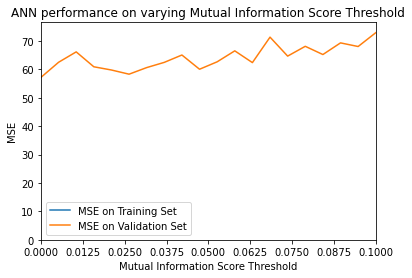

In [88]:
# We use the validation curves from the model without feature selection to choose the structure of the neural network
start_time = time.time()
feature_curve(XX, YY, np.linspace(0, 0.1, num=20) ,np.linspace(0, 0.10, num=9))
print("Time taken: ", time.time() - start_time)

In [ ]:
best_fs_threshold = 0# from the above feature curve

Predicted vs True

In [ ]:
# This will be the same as the predicted vs true from before

# Appropriateness Dataset with Augmented Data

In [13]:
jerks_path = "Synthesised_Dataset/Appropriateness_Features/mean_jerk_values.csv"
XX_jerks = pd.read_csv(jerks_path) # With Spine joint and Name of "Cond/StudySeq"

accels_path = "Synthesised_Dataset/Appropriateness_Features/mean_acceleration_values.csv"
XX_accels = pd.read_csv(accels_path) # With Spine joint and Name of "Cond/StudySeq"

pairwise_path = "Synthesised_Dataset/Appropriateness_Features/mean_pairwise_joint_distances.csv"
XX_pairwise = pd.read_csv(pairwise_path) # With Spine joint and Name of "Cond/StudySeq"
XX_pairwise.drop(XX_pairwise.columns[range(1,15)], axis=1, inplace=True) # Without Spine Joint but with Name of "Cond/StudySeq"

rms_properties_path = "Synthesised_Dataset/Appropriateness_Features/RMS_Energy_properties.csv"
XX_rms_energy_properties = pd.read_csv(rms_properties_path, index_col = False) # With Name of StudySeq

rms_distance_path = "Synthesised_Dataset/Appropriateness_Features/RMS_Distance_scores_fd_scaled.csv"
XX_rms_distance_scores = pd.read_csv(rms_distance_path)
XX_rms_distance_scores.drop(XX_rms_distance_scores.columns[1], axis=1, inplace=True) # Dropping the Spine joint (always 0)

labels_path = "Synthesised_Dataset/Appropriateness_Labels/mean_opinion_scores.csv"
YY = pd.read_csv(labels_path) # # With Name of "Cond/StudySeq"

In [14]:
XY = XX_jerks.join(YY, lsuffix="_jerks", rsuffix="_YY")
XY = XY.join(XX_accels, rsuffix='_accels')
XY = XY.rename(columns={'Unnamed: 0': 'Unnamed: 0_accels'})
XY = XY.join(XX_pairwise, rsuffix='_pairwise')
XY = XY.rename(columns={'Unnamed: 0': 'Unnamed: 0_pairwise'})
XY = XY.join(XX_rms_distance_scores)
XY = XY.rename(columns={'Unnamed: 0': 'Unnamed: 0_rms_distance_scores'})

In [15]:
# Join the RMS Energy Properties Features
XY = XY.rename(columns={'Unnamed: 0_jerks': 'StudySeq'})
XY['Cond'] = XY['StudySeq'].apply(lambda x: x[:x.index('/')])
XY['StudySeq'] = XY['StudySeq'].apply(lambda x: x[x.index('q')+1:]) # Remove info on Cond
XY = XY.join(XX_rms_energy_properties, rsuffix='_rms')
for i in range(1,int(XY.shape[0]/80)):
    XY.iloc[i*80:(i+1)*80,-5:] = XX_rms_energy_properties

In [16]:
# Drop the Names of "Cond/StudySeq" and remaining information relating to the "Spine" joint
# Also Drop the Index from rms_energy
XY.drop(['Unnamed: 0_YY','Unnamed: 0_accels', 'Unnamed: 0_pairwise', 'Spine', 'Spine_accels',
        'Unnamed: 0_rms_distance_scores', 'Unnamed: 0', 'StudySeq_rms'], axis=1, inplace=True)

rename_dict = dict(zip(XY.columns[1:15], XY.columns[1:15] + '_jerks'))
XY = XY.rename(columns=rename_dict)

# Jerk for 14 joints + Acceleration for 14 joints + 14 choose 2 pairwise distance + 14 RMS Energy Distance Scores + 3 RMS Energy Property Features + Label for MOS = 137
print(XY.shape)

(7200, 139)


In [17]:
cols = XY.columns.tolist()
cols.remove('Cond')
cols = ['Cond'] + cols
XY = XY[cols]

In [18]:
XY['StudySeq'] = pd.to_numeric(XY['StudySeq'])
XX = XY.drop(['Mean_Appropriateness_Score'], axis=1, inplace=False)
bad_features = ['LeftShoulder_vs_LeftArm', 'LeftArm_vs_LeftForeArm', 'LeftForeArm_vs_LeftHand',
                'RightShoulder_vs_RightArm', 'RightArm_vs_RightForeArm','RightForeArm_vs_RightHand']
XX.drop(bad_features, axis=1, inplace=True)
YY = XY[['Cond', 'StudySeq', 'Mean_Appropriateness_Score']]
XX.iloc[:,2:] = np.log(XX.iloc[:,2:])
print(XX.shape)
print(YY.shape)

(7200, 132)
(7200, 3)


198.63134441390545


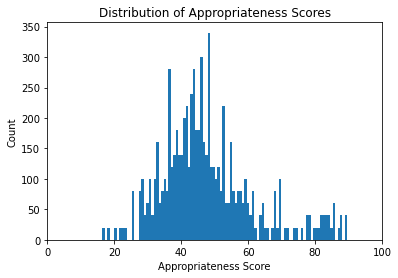

In [19]:
plt.hist(YY['Mean_Appropriateness_Score'], bins = 100)
plt.xlim(0,100)
plt.xlabel("Appropriateness Score")
plt.ylabel("Count")
plt.title("Distribution of Appropriateness Scores")
var = np.var(YY['Mean_Appropriateness_Score'])
print(var)

In [20]:
XX.describe()

,StudySeq,Spine1_jerks,Spine2_jerks,Spine3_jerks,LeftShoulder_jerks,LeftArm_jerks,LeftForearm_jerks,LeftHand_jerks,RightShoulder_jerks,RightArm_jerks,...,RightShoulder_RMS_Distance_Score,RightArm_RMS_Distance_Score,RightForeArm_RMS_Distance_Score,RightHand_RMS_Distance_Score,Neck_RMS_Distance_Score,Neck1_RMS_Distance_Score,Head_RMS_Distance_Score,min_RMS_Energy,max_RMS_Energy,mean_RMS_Energy
count,7200.000000,7200.000000,7200.000000,7200.000000,7200.000000,7200.000000,7200.000000,7200.000000,7200.000000,7200.000000,...,7200.000000,7200.000000,7200.000000,7200.000000,7200.000000,7200.000000,7200.000000,7200.000000,7200.000000,7200.000000
mean,400.500000,7.238224,7.366150,7.502528,7.643845,7.818509,8.371011,8.832591,7.643845,7.818509,...,-0.861053,-0.739701,-0.739745,-0.405888,-0.859546,-0.875652,-0.864515,-3.696289,-0.866533,-1.614794
std,230.955966,0.700900,0.544234,0.469295,0.428828,0.392611,0.479328,0.461389,0.428828,0.392611,...,0.242335,0.294201,0.206041,0.223511,0.246200,0.254507,0.266081,0.797139,0.272385,0.289059
min,1.000000,3.655330,4.439885,4.900368,5.196570,5.435678,6.282438,6.804531,5.196570,5.435678,...,-4.605170,-4.605170,-4.605170,-4.605170,-4.605170,-4.605170,-4.605170,-5.366736,-1.395301,-2.128564
25%,200.750000,7.379390,7.453055,7.553634,7.668211,7.792639,8.063996,8.517175,7.668211,7.792639,...,-0.913916,-0.775950,-0.748576,-0.413352,-0.917868,-0.939943,-0.928811,-4.170783,-1.030628,-1.822282
50%,400.500000,7.420968,7.500836,7.606680,7.729511,7.864279,8.241831,8.749755,7.729511,7.864279,...,-0.854643,-0.719838,-0.732253,-0.399288,-0.851712,-0.866712,-0.853659,-3.590974,-0.886227,-1.608296
75%,600.250000,7.463648,7.556748,7.674101,7.799836,7.980365,8.621657,9.125945,7.799836,7.980365,...,-0.788465,-0.650370,-0.714421,-0.383054,-0.782840,-0.790458,-0.780005,-3.330635,-0.686539,-1.348266
max,800.000000,7.964174,7.989612,8.100524,8.316989,8.586239,9.852115,10.339779,8.316989,8.586239,...,0.009950,0.009950,0.009950,0.009950,0.009950,0.009950,0.009950,-2.109763,-0.139434,-1.058574


# Functions

In [21]:
# studyseqs_to_keep should be a list of the studyseq indexes to keep (e.g. [1,2,3,4....,40] for the original unaugmented data)
def reduce_dataset_size(XX, YY, studyseqs_to_keep):
    reduced_XX = XX[XX['StudySeq'].isin(studyseqs_to_keep)]
    reduced_YY = YY[YY['StudySeq'].isin(studyseqs_to_keep)]
    return reduced_XX, reduced_YY

In [22]:
def split_by_cond(XX, YY, cond_to_split):
    reduced_XX = XX[XX['Cond'].isin([cond_to_split]) == False]
    reduced_YY = YY[YY['Cond'].isin([cond_to_split]) == False]
    cond_XX = XX[XX['Cond'].isin([cond_to_split])]
    cond_YY = YY[YY['Cond'].isin([cond_to_split])]
    return reduced_XX, reduced_YY, cond_XX, cond_YY

In [23]:
def get_rand_studyseqs(duplicates_to_keep):
    iteration = [x for x in range(1,20)]
    random.shuffle(iteration)
    studyseqs_to_keep = [x for x in range(1,41)]
    for i in range(0,duplicates_to_keep):
        start_idx = (iteration[i]*40)+1
        end_idx = ((iteration[i]+1)*40)+1
        studyseqs_to_keep = studyseqs_to_keep + [x for x in range(start_idx,end_idx)] 
    return studyseqs_to_keep

In [24]:
def leave_one_out_folds(XX, YY, conds):
    cv_splits = []
    XX.index = np.arange(0, len(XX))
    for cond in conds:
        train_index = XX[XX['Cond'].isin([cond]) == False].index
        val_index = XX[XX['Cond'].isin([cond])].index[:40]
        split = (train_index.to_numpy(), val_index.to_numpy())
        cv_splits = cv_splits + [split]
    return cv_splits

In [25]:
def single_leave_one_out_fold(XX, YY, val_cond):
    train_index = XX[XX['Cond'].isin([val_cond]) == False].index
    val_index = XX[XX['Cond'].isin([val_cond])].index[:40] # We don't want to change the validation and test set size with data augmentation
    cv_split = [(train_index.to_numpy(), val_index.to_numpy())]
    return cv_split

In [26]:
# Performs k-fold cross validation to find the best train set size
def learning_curve(XX, YY, anti_overfit):
    pd.options.mode.chained_assignment = None
    Conds = ['Cond_BA', 'Cond_BT', 'Cond_N', 'Cond_M', 'Cond_SA', 'Cond_SB', 'Cond_SC', 'Cond_SD', 'Cond_SE']
    standard_iteration = [x for x in range(1,20)] # The iteration over which we add/remove data
    num_of_shuffles = 2
    
    shuffled_train_mse = []
    shuffled_val_mse = []
    shuffled_sizes = []
    for n in range(num_of_shuffles):
        random.shuffle(standard_iteration)
        train_mse_vals = []
        mse_vals = []
        size_vals = []
        for outer_cond in Conds:
            XX_train, YY_train, XX_cond, YY_cond = split_by_cond(XX, YY, outer_cond)
            remaining_conds = Conds[:]
            remaining_conds.remove(outer_cond)

            outer_train_mse_vals = []
            outer_mse_vals = []
            outer_size_vals = []
            for inner_cond in remaining_conds: # performing k fold cross validation holding out one cond on each fold
                split_XX_train, split_YY_train, XX_val, YY_val = split_by_cond(XX_train, YY_train, inner_cond)
                inner_train_mse_vals = []
                inner_mse_vals = []
                inner_size_vals = []
                studyseqs_to_keep = [x for x in range(1,41)]
                for i in standard_iteration + ['end']: # we should never reach the 'end'
                    reduced_XX_train, reduced_YY_train = reduce_dataset_size(split_XX_train, split_YY_train, studyseqs_to_keep)
                    reduced_XX_val, reduced_YY_val = reduce_dataset_size(XX_val, YY_val, [x for x in range(1,41)]) # Don't change the validation set size

                    # drop the StudySeq and Cond columns
                    reduced_XX_train.drop(['Cond','StudySeq'], inplace=True, axis=1)
                    reduced_YY_train.drop(['Cond','StudySeq'], inplace=True, axis=1)
                    reduced_XX_val.drop(['Cond','StudySeq'], inplace=True, axis=1)
                    reduced_YY_val.drop(['Cond','StudySeq'], inplace=True, axis=1)

                    reduced_YY_train = reduced_YY_train.values.flatten()
                    reduced_YY_val = reduced_YY_val.values.flatten()
                    
                    model = Sequential()
                    model.add(Dense(14, input_dim=len(reduced_XX_train.columns), activation='relu')) # hidden layer 1
                    model.add(Dense(14)) #2 
                    model.add(Dense(14)) #3 
                    model.add(Dense(14)) #4 
                    model.add(Dense(14)) #5 
                    model.add(Dense(14)) #6
                    model.add(Dense(1))
                    model.add(Dense(1))
                    model.compile(optimizer = 'adam', loss='mse')

                    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20)

                    history = model.fit(reduced_XX_train, reduced_YY_train, epochs=250,
                                        validation_data=(reduced_XX_val, reduced_YY_val), 
                                        batch_size=len(reduced_XX_train.index),
                                        verbose = 0, callbacks = [callback])
                    


                    train_mse = min(history.history['loss'])
                    inner_train_mse_vals = inner_train_mse_vals + [train_mse]
                    mse = history.history['val_loss'][history.history['loss'].index(min(history.history['loss']))]
                    inner_mse_vals = inner_mse_vals + [mse]

                    train_size = len(reduced_XX_train.index)
                    inner_size_vals = inner_size_vals + [train_size]
                    if (i != 'end'):
                        start_idx = (i*40)+1
                        end_idx = ((i+1)*40)+1
                        studyseqs_to_keep = studyseqs_to_keep + [x for x in range(start_idx,end_idx)] # add next bit of data
                #print(outer_cond, inner_cond, [int(x) for x in inner_mse_vals])
                if (anti_overfit == True):
                    if (not(inner_cond == 'Cond_N' and outer_cond == 'Cond_M') and not(inner_cond =='Cond_M' and outer_cond == 'Cond_N')):
                        outer_train_mse_vals = outer_train_mse_vals + [inner_train_mse_vals]
                        outer_mse_vals = outer_mse_vals + [inner_mse_vals]
                        outer_size_vals = outer_size_vals + [inner_size_vals]
                else:
                    outer_train_mse_vals = outer_train_mse_vals + [inner_train_mse_vals]
                    outer_mse_vals = outer_mse_vals + [inner_mse_vals]
                    outer_size_vals = outer_size_vals + [inner_size_vals]
            train_mse_vals = train_mse_vals + [np.mean(np.asarray(outer_train_mse_vals), axis=0)]
            mse_vals = mse_vals + [np.mean(np.asarray(outer_mse_vals), axis=0)]
            size_vals = size_vals + [np.mean(np.asarray(outer_size_vals), axis=0)]
            print('Shuffle: ', str(n+1), '/', str(num_of_shuffles), ' Outer Cond:', 
                  str(Conds.index(outer_cond)+1), '/', str(len(Conds)))
        #for i in range(0, len(mse_vals)):
            #plt.plot(size_vals[i], mse_vals[i], label=Conds[i] + ' held out of training set')
    
        train_mse_vals = np.mean(np.asarray(train_mse_vals), axis=0)
        mse_vals = np.mean(np.asarray(mse_vals), axis=0)
        size_vals = np.mean(np.asarray(size_vals), axis=0)
        
        shuffled_train_mse = shuffled_train_mse + [train_mse_vals]
        shuffled_val_mse = shuffled_val_mse + [mse_vals]
        shuffled_sizes = shuffled_sizes + [size_vals]

    mean_train_mse = np.mean(np.asarray(shuffled_train_mse), axis=0)
    mean_val_mse = np.mean(np.asarray(shuffled_val_mse), axis=0)
    mean_sizes = np.mean(np.asarray(shuffled_sizes), axis=0)
    
    train_mse_sem = sem(np.asarray(shuffled_train_mse), axis=0)
    val_mse_sem = sem(np.asarray(shuffled_val_mse), axis=0)
    
    plt.plot(np.arange(0,20,1), mean_train_mse, label='Training Set MSE')
    plt.fill_between(np.arange(0,20,1), mean_train_mse - train_mse_sem, mean_train_mse + train_mse_sem, alpha=0.5)
    plt.plot(np.arange(0,20,1), mean_val_mse, label='Validation Set MSE')
    plt.fill_between(np.arange(0,20,1), mean_val_mse - val_mse_sem, mean_val_mse + val_mse_sem, alpha=0.5)
    plt.ylim(0, max([max(mean_train_mse), max(mean_val_mse)]) + max([max(train_mse_sem), max(val_mse_sem)]))
    plt.xlim(0,19)
    plt.xticks(np.arange(0,20,1))
    plt.xlabel('Number of Augmented Sets')
    plt.ylabel('MSE')
    plt.title('ANN performance\n on different Training Set sizes')
    plt.legend()
    
    best_size = mean_sizes[np.argmin(mean_val_mse)]
    best_duplicates_to_keep = np.argmin(mean_val_mse)
    print('Best Train Set Size (Excluding validation set of same proportion) = ', best_size)
    print('Duplicates to keep = ', best_duplicates_to_keep)
    return best_duplicates_to_keep, best_size

In [27]:
# Model name is just the type of algorithm e.g. Linear Regression or kNN
def predicted_vs_true(model, XX, YY, best_duplicates_to_keep, anti_overfit):
    Conds = ['Cond_BA', 'Cond_BT', 'Cond_N', 'Cond_M', 'Cond_SA', 'Cond_SB', 'Cond_SC', 'Cond_SD', 'Cond_SE']
    XX_reduced, YY_reduced = reduce_dataset_size(XX, YY, get_rand_studyseqs(best_duplicates_to_keep))
    YY_preds = []
    YY_test_true = []
    YY_train_preds = []
    YY_train_true = []
    count = 1
    model.save_weights('initial_hl.h5')
    for cond in Conds: # kfolds for testing
        model.load_weights('initial_hl.h5')
        XX_train, YY_train, XX_test, YY_test = split_by_cond(XX_reduced, YY_reduced, cond)
        
        if (anti_overfit == True):
            if (cond == 'Cond_N' or cond == 'Cond_M'):
                # Make sure one of Cond_N or Cond_M is always in the train set
                train_val_conds = Conds[:]
                train_val_conds.remove('Cond_N')
                train_val_conds.remove('Cond_M')
            else: 
                train_val_conds = Conds[:]
                train_val_conds.remove(cond)
        else:
            train_val_conds = Conds[:]
            train_val_conds.remove(cond)


        
        # Data augmentation does not change the test and validation set
        XX_train, YY_train, XX_test, YY_test = XX_train.iloc[:,2:], YY_train.iloc[:,2:], XX_test.iloc[:40,2:], YY_test.iloc[:40,2:] # drop studyseq idx and cond columns
        YY_train, YY_test = YY_train.values.flatten(), YY_test.values.flatten()
        
        callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20)

        model.fit(XX_train, YY_train, epochs=1000, validation_split=0, batch_size=len(XX_train.index), verbose = 0, 
                 callbacks = [callback])
        YY_pred = model.predict(XX_test)
        YY_preds = YY_preds + list(YY_pred.flatten())
        YY_test_true = YY_test_true + list(YY_test)
        
        YY_train_preds = YY_train_preds + list(model.predict(XX_train).flatten())
        YY_train_true = YY_train_true + list(YY_train)
        
        print('Outer Fold ', count, '/', 9, ' completed.')
        count = count + 1
    YY_train_preds = np.clip(YY_train_preds, 0, 100)
    YY_preds = np.clip(YY_preds, 0, 100)
    m, b = np.polyfit(YY_preds, YY_test_true, 1)
    x = np.arange(0,101)
    y = np.arange(0,101)



    plt.figure(figsize = (7,7))
    plt.scatter(YY_preds, YY_test_true, s=7.5, alpha=0.8, label="Predictions")
    plt.plot(x, y*m + b, '-c', label="Regression Line for predictions")
    plt.plot(x, y, "-k", label="Regression Line for p=1", alpha=0.5)
    plt.title("Predictions of ANN on Test Set")
    plt.ylabel("True Appropriateness")
    plt.xlabel("Predicted Appropriateness")
    plt.xticks(np.linspace(0,100,11))
    plt.yticks(np.linspace(0,100,11))
    plt.xlim(0,100)
    plt.ylim(0,100)
    plt.legend()

    rho, pval = stats.spearmanr(YY_test_true, YY_preds)
    print("Pearson Correlation Coefficient =", rho)
    print("Test Mean Squared Error = ", mean_squared_error(YY_test_true, YY_preds, squared=True))
    print("Train Mean Squared Error = ", mean_squared_error(YY_train_true, YY_train_preds, squared=True))

Augmented Sets vs MSE

Shuffle:  1 / 2  Outer Cond: 1 / 9
Shuffle:  1 / 2  Outer Cond: 2 / 9
Shuffle:  1 / 2  Outer Cond: 3 / 9
Shuffle:  1 / 2  Outer Cond: 4 / 9
Shuffle:  1 / 2  Outer Cond: 5 / 9
Shuffle:  1 / 2  Outer Cond: 6 / 9
Shuffle:  1 / 2  Outer Cond: 7 / 9
Shuffle:  1 / 2  Outer Cond: 8 / 9
Shuffle:  1 / 2  Outer Cond: 9 / 9
Shuffle:  2 / 2  Outer Cond: 1 / 9
Shuffle:  2 / 2  Outer Cond: 2 / 9
Shuffle:  2 / 2  Outer Cond: 3 / 9
Shuffle:  2 / 2  Outer Cond: 4 / 9
Shuffle:  2 / 2  Outer Cond: 5 / 9
Shuffle:  2 / 2  Outer Cond: 6 / 9
Shuffle:  2 / 2  Outer Cond: 7 / 9
Shuffle:  2 / 2  Outer Cond: 8 / 9
Shuffle:  2 / 2  Outer Cond: 9 / 9
Best Train Set Size (Excluding validation set of same proportion) =  1960.0
Duplicates to keep =  6


(6, 1960.0)

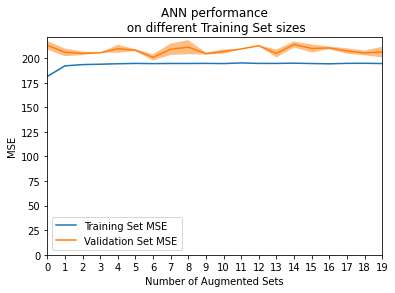

In [52]:
learning_curve(XX, YY, True) 

In [28]:
best_duplicates_to_keep = 6 

Predicted vs True with Best Duplicates to keep

Outer Fold  1 / 9  completed.
Outer Fold  2 / 9  completed.
Outer Fold  3 / 9  completed.
Outer Fold  4 / 9  completed.
Outer Fold  5 / 9  completed.
Outer Fold  6 / 9  completed.
Outer Fold  7 / 9  completed.
Outer Fold  8 / 9  completed.
Outer Fold  9 / 9  completed.
Pearson Correlation Coefficient = -0.2642251248677368
Test Mean Squared Error =  272.8995584727767
Train Mean Squared Error =  172.93777605737293
Time taken:  29.351210832595825


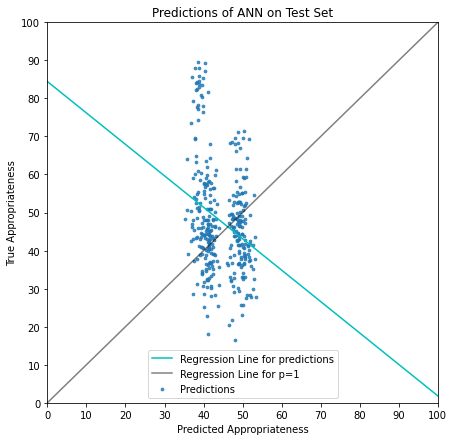

In [29]:
start_time = time.time()
model = Sequential()
model.add(Dense(14, input_dim=130, activation='relu')) # hidden layer 1
model.add(Dense(14)) #2 
model.add(Dense(14)) #3 
model.add(Dense(14)) #4 
model.add(Dense(14)) #5 
model.add(Dense(14)) #6
model.add(Dense(1))
model.compile(optimizer = 'adam', loss='mse')
predicted_vs_true(model, XX, YY, best_duplicates_to_keep, True)
print("Time taken: ", time.time() - start_time)

Predicted vs True with 1 augmented set

Outer Fold  1 / 9  completed.
Outer Fold  2 / 9  completed.
Outer Fold  3 / 9  completed.
Outer Fold  4 / 9  completed.
Outer Fold  5 / 9  completed.
Outer Fold  6 / 9  completed.
Outer Fold  7 / 9  completed.
Outer Fold  8 / 9  completed.
Outer Fold  9 / 9  completed.
Pearson Correlation Coefficient = 0.01811833910360077
Test Mean Squared Error =  217.29089555887893
Train Mean Squared Error =  177.0837300524348
Time taken:  21.57977533340454


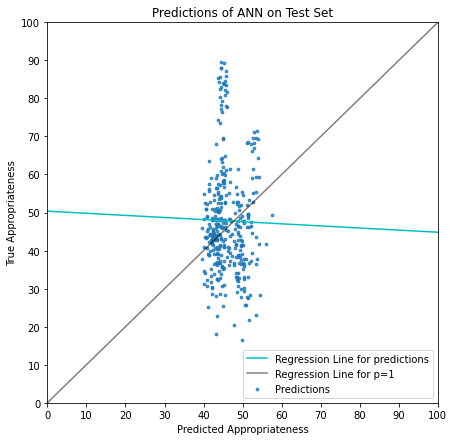

In [19]:
start_time = time.time()
model = Sequential()
model.add(Dense(14, input_dim=130, activation='relu')) # hidden layer 1
model.add(Dense(14)) #2 
model.add(Dense(14)) #3 
model.add(Dense(14)) #4 
model.add(Dense(14)) #5 
model.add(Dense(14)) #6
model.add(Dense(1))
model.compile(optimizer = 'adam', loss='mse')
predicted_vs_true(model, XX, YY, 1, True)
print("Time taken: ", time.time() - start_time)